In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
model_names = ['gemma2', 'gemma', 'mistral']

In [2]:
def jsonl_to_df():
    # 初始化一个空的列表来存储每行的字典
    file_path = 'D:/git-code/updated_code/ollama_fact/json_file/LLM_result_jsonl/Factual_verification.jsonl'
    data = []
    
    # 打开 JSONL 文件并逐行读取
    with open(file_path, 'r') as file:
        for line in file:
            # 解析每行 JSON 数据并添加到列表中
            data.append(json.loads(line))
    
    # 使用 Pandas 将列表转换为 DataFrame
    df = pd.DataFrame(data)
    return df
df = jsonl_to_df()


In [3]:
df

,person,text,label,model,judgement,token_allocation,res
0,Abdou Diallo,1.87 m is 6 ft 2 in.,NS,gemma,True,80,## Token Allocation and Judgement\n\n**Judgeme...
1,Abdou Diallo,1.87 m is 6 ft 2 in.,NS,gemma2,True,90,"```json\n{\n ""judgement"": ""True"",\n ""token_all..."
2,Abdou Diallo,1.87 m is 6 ft 2 in.,NS,mistral,True,95,"<token_allocation>\n<json>\n{""judgement"": ""Tr..."
3,Abdou Diallo,Abdou Diallo currently plays for a Bundesliga ...,S,gemma,uncertain,0,## Judgement: Uncertain\n\n**Reasoning:** Desp...
4,Abdou Diallo,Abdou Diallo currently plays for a Bundesliga ...,S,gemma2,True,80,"<token_allocation>\n<json>\n{""judgement"": ""Tru..."
...,...,...,...,...,...,...,...
27907,Zelma Wilson,Zelma worked to promote equal employment oppor...,NS,gemma2,True,70,"<token_allocation>\n<json>\n{""judgement"": ""Tru..."
27908,Zelma Wilson,Zelma worked to promote equal employment oppor...,NS,mistral,True,90,"<token_allocation>\n<json>\n{""judgement"": ""Tr..."
27909,Zelma Wilson,Zelma's age was 73 at the time of her passing.,NS,gemma,True,80,## Judgement and Token Allocation\n\n**Judgeme...
27910,Zelma Wilson,Zelma's age was 73 at the time of her passing.,NS,gemma2,uncertain,0,"<token_allocation>\n<json>\n{""judgement"": ""unc..."


In [269]:
ls_sub = df['subject'].unique()
dc_sub = {}
for i in range(len(ls_sub)):
    dc_sub[ls_sub[i]] = i


In [245]:
data.shape

(13936, 20)

In [270]:
from collections import defaultdict
questions = defaultdict(lambda : defaultdict(dict))
for i, row in df.iterrows():
    question, label, model, token_A, token_B, token_C, token_D, subject = row.question_choices, row.answer, row.model, row.A, row.B, row.C, row.D, dc_sub[row.subject]
    questions[question]['label'] = label
    questions[question]['subject'] = subject
    questions[question][model]['token_A'] = token_A
    questions[question][model]['token_B'] = token_B
    questions[question][model]['token_C'] = token_C
    questions[question][model]['token_D'] = token_D
    questions[question][model]['uncertainty'] = 1 - max([token_A,token_B,token_C,token_D]) / 100
    if (token_A+token_B+token_C+token_D) == 0: questions[question][model]['pred'] = 4
    else: questions[question][model]['pred'] = np.array([token_A,token_B,token_C,token_D]).argmax()
data = []

for q, v in questions.items():
    text_data = []
    sj = v['subject']
    gt = v['label']
    for model in model_names:
        text_data = text_data + [v[model]['pred'], v[model]['token_A'], v[model]['token_B'], v[model]['token_C'], v[model]['token_D'], v[model]['uncertainty']]
    text_data.append(sj)
    text_data.append(gt)
    data.append(text_data)
data = np.array(data)

In [271]:
random_state = 60  # random init
n_estimators = 100
model_names

['gemma2', 'gemma', 'mistral']

In [238]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = " "
aug_data = data[:, :-1].copy()
for i in [0,6,12]:
    embedding = nn.Embedding(num_embeddings=5, embedding_dim=3)  # 10个类别，每个类别映射到4维空间
    category_tensor = torch.tensor(aug_data[:,i].flatten()).long()  # 假设类别特征为0,1,2
    embedded_tensor = embedding(category_tensor)     
    aug_data = np.append(aug_data,values=embedded_tensor.detach().numpy(),axis=1)
embedding = nn.Embedding(num_embeddings=57, embedding_dim=6)  # 10个类别，每个类别映射到4维空间
category_tensor = torch.tensor(aug_data[:,18].flatten()).long()  # 假设类别特征为0,1,2
embedded_tensor = embedding(category_tensor)     
aug_data = np.append(aug_data,values=embedded_tensor.detach().numpy(),axis=1)
aug_data = np.delete(aug_data,[0,6,12,18],axis=1)

In [272]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.utils.data import Dataset

X = data[:, :-1]  # feature
y = data[:, -1]   # label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')  # 宏平均F1分数
    
    return f1_macro, accuracy, y_pred


# 初始化模型
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
tree_clf = DecisionTreeClassifier(random_state=random_state)
svm_clf = SVC(decision_function_shape='ovr')
rf_clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
xgb_clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
lgb_clf = lgb.LGBMClassifier(num_leaves=15, n_estimators=100, random_state=random_state)
cat_clf = CatBoostClassifier(iterations=100, random_state=random_state, verbose=0)
# 对各个模型进行评估
f1_lr, acc_lr, pred_lr = evaluate_model(log_reg, X_train, y_train, X_test, y_test)
f1_dt, acc_dt, pred_dt = evaluate_model(tree_clf, X_train, y_train, X_test, y_test)
f1_svm,  acc_svm, pred_svm = evaluate_model(svm_clf, X_train, y_train, X_test, y_test)
f1_rf, acc_rf, pred_rf = evaluate_model(rf_clf, X_train, y_train, X_test, y_test)
f1_xgb,  acc_xgb, pred_xgb = evaluate_model(xgb_clf, X_train, y_train, X_test, y_test)
f1_lgb,  acc_lgb, pred_lgb = evaluate_model(lgb_clf, X_train, y_train, X_test, y_test)
f1_cat,  acc_cat, pred_cat = evaluate_model(cat_clf, X_train, y_train, X_test, y_test)

print("Model Comparison:")
# F1-score and Accuracy about models'judgement(prediction)
print('gemma2              - F1-score: {:.4f}, Accuracy: {:.4f}'.format(f1_score(y_test, X_test[:,0], average='macro'), accuracy_score(y_test, X_test[:,0])))
print('gemma               - F1-score: {:.4f}, Accuracy: {:.4f}'.format(f1_score(y_test, X_test[:,6], average='macro'), accuracy_score(y_test, X_test[:,6])))
print('mistral             - F1-score: {:.4f}, Accuracy: {:.4f}'.format(f1_score(y_test, X_test[:,12], average='macro'), accuracy_score(y_test, X_test[:,12])))
print("Logistic Regression - F1-score: {:.4f}, Accuracy: {:.4f}".format(f1_lr, acc_lr))
print("Decision Tree       - F1-score: {:.4f}, Accuracy: {:.4f}".format(f1_dt, acc_dt))
print("SVM                 - F1-score: {:.4f}, Accuracy: {:.4f}".format(f1_svm,  acc_svm))
print("Random Forest       - F1-score: {:.4f}, Accuracy: {:.4f}".format(f1_rf, acc_rf))
print("XGBoost             - F1-score: {:.4f}, Accuracy: {:.4f}".format(f1_xgb,  acc_xgb))
print("LightGBM            - F1-score: {:.4f}, Accuracy: {:.4f}".format(f1_lgb,  acc_lgb))
print("CatBoost            - F1-score: {:.4f}, Accuracy: {:.4f}".format(f1_cat,  acc_cat))

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\anaconda\envs\pytorch\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:11:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboo

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 11148, number of used features: 19
[LightGBM] [Info] Start training from score -1.472425
[LightGBM] [Info] Start training from score -1.406959
[LightGBM] [Info] Start training from score -1.360089
[LightGBM] [Info] Start training from score -1.312648
Model Comparison:
gemma2              - F1-score: 0.4645, Accuracy: 0.5796
gemma               - F1-score: 0.1940, Accuracy: 0.3042
mistral             - F1-score: 0.3117, Accuracy: 0.4042
Logistic Regression - F1-score: 0.5828, Accuracy: 0.5821
Decision Tree       - F1-score: 0.4632, Accuracy: 0.4631
SVM                 - F1-score: 0.6013, Accuracy: 0.6004
Random Forest       - F1-score: 0.5727, Accuracy: 0.5721
XGBoost        

In [ ]:
# HybridNN
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

binary_features = [0, 5, 10]  # 0-1 feature
numeric_features = [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14]  # numerical feature


X = data[:, :-1]  # feature
y = data[:, -1]   # label
X_binary = X[:, binary_features]
X_numeric = X[:, numeric_features]

scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)


X_train_binary, X_test_binary, X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(
    X_binary, X_numeric_scaled, y, test_size=0.2, random_state=random_state)

# PyTorch tensors
X_train_binary = torch.tensor(X_train_binary, dtype=torch.float32)
X_test_binary = torch.tensor(X_test_binary, dtype=torch.float32)
X_train_numeric = torch.tensor(X_train_numeric, dtype=torch.float32)
X_test_numeric = torch.tensor(X_test_numeric, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# GPU 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X_train_binary, X_test_binary = X_train_binary.to(device), X_test_binary.to(device)
# X_train_numeric, X_test_numeric = X_train_numeric.to(device), X_test_numeric.to(device)
# y_train, y_test = y_train.to(device), y_test.to(device)

class HybridNN(nn.Module):
    def __init__(self):
        super(HybridNN, self).__init__()
        # Subnetwork for processing 0-1 features
        self.binary_net = nn.Sequential(
            nn.Linear(len(binary_features), 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        # Subnetwork for processing numerical feature
        self.numeric_net = nn.Sequential(
            nn.Linear(len(numeric_features), 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(8 + 32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x_binary, x_numeric):
        binary_out = self.binary_net(x_binary)
        numeric_out = self.numeric_net(x_numeric)
        combined = torch.cat((binary_out, numeric_out), dim=1)
        output = self.classifier(combined)
        return output

# 实例化模型并移动到 GPU
# model = HybridNN().to(device)
model = HybridNN()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train
epochs = 50
batch_size = 32

train_data = torch.utils.data.TensorDataset(X_train_binary, X_train_numeric, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for binary_inputs, numeric_inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(binary_inputs, numeric_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# eval
model.eval()
with torch.no_grad():
    y_pred = model(X_test_binary, X_test_numeric)
    y_pred_label = (y_pred > 0.5).float()
    accuracy = (y_pred_label == y_test).float().mean()
    print(f"Test Accuracy: {accuracy.item():.4f}")
pred_snn = y_pred_label.cpu().numpy().flatten()



In [ ]:
# GroupedNN
group1_features = [0, 1, 2]  # gemma
group2_features = [3, 4, 5]  # gemma2
group3_features = [6, 7, 8]  # mistral

X_group1 = X[:, group1_features]
X_group2 = X[:, group2_features]
X_group3 = X[:, group3_features]

scaler_group1 = StandardScaler()
scaler_group2 = StandardScaler()
scaler_group3 = StandardScaler()

X_group1_scaled = scaler_group1.fit_transform(X_group1)
X_group2_scaled = scaler_group2.fit_transform(X_group2)
X_group3_scaled = scaler_group3.fit_transform(X_group3)

X_train_group1, X_test_group1, X_train_group2, X_test_group2, X_train_group3, X_test_group3, y_train, y_test = train_test_split(
    X_group1_scaled, X_group2_scaled, X_group3_scaled, y, test_size=0.2, random_state=random_state)

X_train_group1 = torch.tensor(X_train_group1, dtype=torch.float32)
X_test_group1 = torch.tensor(X_test_group1, dtype=torch.float32)
X_train_group2 = torch.tensor(X_train_group2, dtype=torch.float32)
X_test_group2 = torch.tensor(X_test_group2, dtype=torch.float32)
X_train_group3 = torch.tensor(X_train_group3, dtype=torch.float32)
X_test_group3 = torch.tensor(X_test_group3, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 使用 GPU 加速
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X_train_group1, X_test_group1 = X_train_group1.to(device), X_test_group1.to(device)
# X_train_group2, X_test_group2 = X_train_group2.to(device), X_test_group2.to(device)
# X_train_group3, X_test_group3 = X_train_group3.to(device), X_test_group3.to(device)
# y_train, y_test = y_train.to(device), y_test.to(device)

class GroupedNN(nn.Module):
    def __init__(self):
        super(GroupedNN, self).__init__()

        self.group1_net = nn.Sequential(
            nn.Linear(len(group1_features), 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        self.group2_net = nn.Sequential(
            nn.Linear(len(group2_features), 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        self.group3_net = nn.Sequential(
            nn.Linear(len(group3_features), 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 3, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x_group1, x_group2, x_group3):
        group1_out = self.group1_net(x_group1)
        group2_out = self.group2_net(x_group2)
        group3_out = self.group3_net(x_group3)
        combined = torch.cat((group1_out, group2_out, group3_out), dim=1)
        output = self.classifier(combined)
        return output

# 实例化模型并移动到 GPU
model = GroupedNN()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# train
epochs = 50
batch_size = 32

train_data = torch.utils.data.TensorDataset(X_train_group1, X_train _group2, X_train_group3, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for group1_inputs, group2_inputs, group3_inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(group1_inputs, group2_inputs, group3_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# eval
model.eval()
with torch.no_grad():
    y_pred = model(X_test_group1, X_test_group2, X_test_group3)
    y_pred_label = (y_pred > 0.5).float()
    accuracy = (y_pred_label == y_test).float().mean()
    print(f"Test Accuracy: {accuracy.item():.4f}")
pred_gnn = y_pred_label.cpu().numpy().flatten()

In [277]:
# NN
class CustomDataset(Dataset):
    def __init__(self, deep_features, wide_features, categorical_features, labels):
        self.deep_features = deep_features
        self.wide_features = wide_features
        self.categorical_features = categorical_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        deep_feat = self.deep_features[idx]
        wide_feat = self.wide_features[idx]
        cat_feat = self.categorical_features[idx]
        label = self.labels[idx]
        return deep_feat, wide_feat, cat_feat, label
  
# 特征和标签划分
features = data[:, :19]  # 前19列是特征
labels = data[:, 19].astype(int)  # 第19列是标签，转为整数类型
# Wide部分：选择第0, 5, 6, 11, 12, 17列
wide_indices = [0, 5, 6, 11, 12, 17]
wide_features = torch.tensor(features[:, wide_indices], dtype=torch.float32)
# Deep部分：所有特征
deep_features = torch.tensor(features, dtype=torch.float32)
# 类别特征：选择第0, 6, 12, 18列
categorical_indices = [0, 6, 12, 18]
categorical_features = torch.tensor(features[:, categorical_indices], dtype=torch.int64)

deep_train, deep_test, wide_train, wide_test, cat_train, cat_test, labels_train, labels_test = train_test_split(
    deep_features, wide_features, categorical_features, labels, test_size=0.2, random_state=random_state)
# 将数据打包为TensorDataset
train_dataset = CustomDataset(deep_train, wide_train, cat_train, labels_train)
test_dataset = CustomDataset(deep_test, wide_test, cat_test, labels_test)
# 加载数据集，设置batch_size
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Neural Network Class
class DeepAndWideWithTextModel(nn.Module):
    def __init__(self, input_size_deep, input_size_wide, num_classes, embedding_sizes):
        super(DeepAndWideWithTextModel, self).__init__()
        # Wide部分输入的线性层
        self.wide = nn.Linear(input_size_wide, num_classes)
        # Deep部分类别特征嵌入层
        self.embeddings = nn.ModuleList([nn.Embedding(cat_size, embed_size) for cat_size, embed_size in embedding_sizes])
        # Deep部分数值特征的线性层
        deep_input_size = input_size_deep + sum(embed_size for _, embed_size in embedding_sizes)
        self.deep_layers = nn.Sequential(
            nn.Linear(deep_input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes))

    def forward(self, x_deep, x_wide, x_cat):
        # Wide部分
        wide_out = self.wide(x_wide)
        # Deep部分，嵌入类别特征并与数值特征拼接
        embedded_cat = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        embedded_cat = torch.cat(embedded_cat, dim=1)
        # 拼接所有Deep特征
        deep_input = torch.cat([x_deep, embedded_cat], dim=1)
        deep_out = self.deep_layers(deep_input)
        # 输出Wide和Deep部分的加权和
        out = wide_out + deep_out
        return out

# 参数示例
input_size_deep = deep_features.size(1)  # Deep部分特征的维度
input_size_wide = wide_features.size(1)  # Wide部分特征的维度
num_classes = 4  # 标签类别数
unique_vals_per_cat_col = [len(np.unique(features[:, col])) for col in categorical_indices]
# 定义 embedding_dim 的规则
def calculate_embedding_dim(num_unique_values):
    return min(50, int(np.log2(num_unique_values)) + 1)
# 生成 embed_dims 列表
embedding_sizes = [(num_unique_values, calculate_embedding_dim(num_unique_values)) 
              for num_unique_values in unique_vals_per_cat_col]

# 模型实例化
model = DeepAndWideWithTextModel(input_size_deep, input_size_wide, num_classes, embedding_sizes)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# # GPU 支持
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# 训练过程
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # tqdm 包装训练数据加载器
    for i, (x_deep, x_wide, x_cat, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        # 将输入和标签移到 GPU（如果可用）
        x_deep, x_wide, x_cat, labels = x_deep.to(device), x_wide.to(device), x_cat.to(device), labels.to(device).long()
        # labels = labels.long()
        # 清除梯度
        optimizer.zero_grad()
        # 前向传播
        outputs = model(x_deep, x_wide, x_cat)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        # 记录损失
        running_loss += loss.item()
        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    # 打印每个 epoch 的损失和准确率
    if epoch%5 == 0: print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')
# 测试模型
model.eval()
correct = 0
total = 0
pred_NN = np.array([])
with torch.no_grad():
    for i, (x_deep, x_wide, x_cat, labels) in enumerate(tqdm(test_loader, desc="Testing")):
        x_deep, x_wide, x_cat, labels = x_deep.to(device), x_wide.to(device), x_cat.to(device).to(device), labels.to(device)
        # labels = labels.long()
        # 前向传播
        outputs = model(x_deep, x_wide, x_cat)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        pred_NN = np.append(pred_NN, values=predicted.cpu().numpy())
        correct += (predicted == labels).sum().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%')


Epoch 1/10:   0%|          | 0/349 [00:00<?, ?it/s]

Epoch 1/10: 100%|██████████| 349/349 [00:00<00:00, 492.43it/s]


Epoch [1/10], Loss: 1.1444, Accuracy: 55.85%


Epoch 6/10: 100%|██████████| 349/349 [00:00<00:00, 501.34it/s]


Epoch [6/10], Loss: 1.0251, Accuracy: 59.18%


Testing: 100%|██████████| 88/88 [00:00<00:00, 1200.27it/s]

Test Accuracy: 60.62%


In [ ]:
def bucket(model, model_data):
    ns, s = model_data[model][:, 2], model_data[model][:, 3]
    # total_evidence = np.maximum(s, ns)
    total_evidence = (s + ns)
    uncertainty = 1 - total_evidence / 100
    # bucket algorithm
    quantiles = np.percentile(uncertainty, np.arange(10, 101, 10))
    print(f'ten_quantiles:{quantiles}')
    new_uncertainty = np.zeros(len(uncertainty))
    for i, q in enumerate(quantiles):
        if i == 0:
            new_uncertainty[uncertainty <= q] = i * 0.1
        else:
            new_uncertainty[(uncertainty > quantiles[i - 1]) & (uncertainty <= q)] = i * 0.1  
    plt.figure(figsize=(8, 6))
    plt.hist(uncertainty, bins=10, edgecolor='black', alpha=0.7)
    plt.title(f'uncertainty of {model}')
    plt.xlabel('Uncertainty')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [276]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, deep_features, wide_features, categorical_features, question_tensor, labels):
        self.deep_features = deep_features
        self.wide_features = wide_features
        self.categorical_features = categorical_features
        self.question_tensor = question_tensor
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        deep_feat = self.deep_features[idx]
        wide_feat = self.wide_features[idx]
        cat_feat = self.categorical_features[idx]
        question_feat = self.question_tensor[idx]
        label = self.labels[idx]
        return deep_feat, wide_feat, cat_feat, question_feat, label
        
df_text = pd.DataFrame(df['question_choices'].unique(),columns=['question_choices'])
# 特征和标签划分
features = data[:, :19]  # 前19列是特征
labels = data[:, 19].astype(int)  # 第19列是标签，转为整数类型
# Wide部分：选择第0, 5, 6, 11, 12, 17列
wide_indices = [0, 5, 6, 11, 12, 17]
wide_features = torch.tensor(features[:, wide_indices], dtype=torch.float32)
# Deep部分：所有特征
deep_features = torch.tensor(features, dtype=torch.float32)
# 类别特征：选择第0, 6, 12, 18列
categorical_indices = [0, 6, 12, 18]
categorical_features = torch.tensor(features[:, categorical_indices], dtype=torch.int64)
# 文本数据预处理
tokenizer = get_tokenizer("basic_english")  # 使用基本分词器
# max_seq_len = 300
def tokenize_and_encode(text_series, vocab):
    tokenized = [torch.tensor([vocab[token] for token in tokenizer(sentence)], dtype=torch.long) for sentence in text_series]
    # tokenized = [torch.tensor([vocab[token] for token in tokenizer(sentence)][:max_seq_len], dtype=torch.long) for sentence in text_series]
    return pad_sequence(tokenized, batch_first=True)  # 填充为相同长度
# 构建词汇表
all_text = df_text['question_choices']
tokenized_text = [tokenizer(sentence) for sentence in all_text]
vocab = {word: idx for idx, word in enumerate(set([word for sent in tokenized_text for word in sent]))}
# 将文本数据转换为数值
question_tensor = tokenize_and_encode(df_text['question_choices'], vocab)

deep_train, deep_test, wide_train, wide_test, cat_train, cat_test, text_train, text_test, labels_train, labels_test = train_test_split(
    deep_features, wide_features, categorical_features, question_tensor, labels, test_size=0.2, random_state=random_state)
# 将数据打包为TensorDataset
train_dataset = CustomDataset(deep_train, wide_train, cat_train, text_train, labels_train)
test_dataset = CustomDataset(deep_test, wide_test, cat_test, text_test, labels_test)
# 加载数据集，设置batch_size
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Neural Network Class
class DeepAndWideWithTextModel(nn.Module):
    def __init__(self, input_size_deep, input_size_wide, num_classes, embedding_sizes, text_embedding_size, vocab_size, hidden_size):
        super(DeepAndWideWithTextModel, self).__init__()
        # Wide部分输入的线性层
        self.wide = nn.Linear(input_size_wide, num_classes)
        # Deep部分类别特征嵌入层
        self.embeddings = nn.ModuleList([nn.Embedding(cat_size, embed_size) for cat_size, embed_size in embedding_sizes])
        # 文本嵌入层
        self.text_embedding = nn.Embedding(vocab_size, text_embedding_size)
        # 用LSTM处理文本特征
        self.lstm = nn.LSTM(input_size=text_embedding_size, hidden_size=hidden_size, batch_first=True)
        # Deep部分数值特征的线性层
        deep_input_size = input_size_deep + sum(embed_size for _, embed_size in embedding_sizes) + hidden_size
        self.deep_layers = nn.Sequential(
            nn.Linear(deep_input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes))

    def forward(self, x_deep, x_wide, x_cat, x_question):
        # Wide部分
        wide_out = self.wide(x_wide)
        # Deep部分，嵌入类别特征并与数值特征拼接
        embedded_cat = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        embedded_cat = torch.cat(embedded_cat, dim=1)
        # 文本特征处理
        embedded_question = self.text_embedding(x_question)
        # 假设你有每个序列的长度
        lengths = [len(seq) for seq in x_question]  # 根据实际情况得到每个文本序列的长度
        packed = pack_padded_sequence(embedded_question, lengths, batch_first=True, enforce_sorted=False)
        # 传入LSTM
        packed_output, (hidden_question, _) = self.lstm(packed)
        # 拼接所有Deep特征
        deep_input = torch.cat([x_deep, embedded_cat, hidden_question.squeeze(0)], dim=1)
        deep_out = self.deep_layers(deep_input)
        # 输出Wide和Deep部分的加权和
        out = wide_out + deep_out
        return out

# 参数示例
input_size_deep = deep_features.size(1)  # Deep部分特征的维度
input_size_wide = wide_features.size(1)  # Wide部分特征的维度
num_classes = 4  # 标签类别数
text_embedding_size = 50  # 文本嵌入维度
vocab_size = len(vocab)  # 词汇表大小
hidden_size = 64  # LSTM的隐状态维度
unique_vals_per_cat_col = [len(np.unique(features[:, col])) for col in categorical_indices]
# 定义 embedding_dim 的规则
def calculate_embedding_dim(num_unique_values):
    return min(50, int(np.log2(num_unique_values)) + 1)
# 生成 embed_dims 列表
embedding_sizes = [(num_unique_values, calculate_embedding_dim(num_unique_values)) 
              for num_unique_values in unique_vals_per_cat_col]

# 模型实例化
model = DeepAndWideWithTextModel(input_size_deep, input_size_wide, num_classes, embedding_sizes, text_embedding_size, vocab_size, hidden_size)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# # GPU 支持
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# 训练过程
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # tqdm 包装训练数据加载器
    for i, (x_deep, x_wide, x_cat, x_question, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        # 将输入和标签移到 GPU（如果可用）
        x_deep, x_wide, x_cat, x_question, labels = x_deep.to(device), x_wide.to(device), x_cat.to(device), x_question.to(device), labels.to(device).long()
        # labels = labels.long()
        # 清除梯度
        optimizer.zero_grad()
        # 前向传播
        # outputs = model(x_deep, x_wide, x_cat, x_question)
        try:
            outputs = model(x_deep, x_wide, x_cat, x_question)
        except IndexError as e:
            # print(f"Max index in x_cat: {x_cat.max().item()}, Embedding size: {self.embeddings[0].num_embeddings}")
            print(f"Error in batch {i}: {e}")
            continue
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        # 记录损失
        running_loss += loss.item()
        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    # 打印每个 epoch 的损失和准确率
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')
# 测试模型
model.eval()
correct = 0
total = 0
pred_text_NN = np.array([])
with torch.no_grad():
    for i, (x_deep, x_wide, x_cat, x_question, labels) in enumerate(tqdm(test_loader, desc="Testing")):
        x_deep, x_wide, x_cat, x_question, labels = x_deep.to(device), x_wide.to(device), x_cat.to(device), x_question.to(device), labels.to(device)
        # labels = labels.long()
        # 前向传播
        # outputs = model(x_deep, x_wide, x_cat, x_question)
        try:
            outputs = model(x_deep, x_wide, x_cat, x_question)
        except IndexError as e:
            # print(f"Max index in x_cat: {x_cat.max().item()}, Embedding size: {self.embeddings[0].num_embeddings}")
            # print(f"Error in batch {i}: {e}")
            continue
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        pred_text_NN = np.append(pred_text_NN, values=predicted.cpu().numpy())
        correct += (predicted == labels).sum().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%')



Epoch 1/10: 100%|██████████| 349/349 [00:13<00:00, 25.10it/s]


Epoch [1/10], Loss: 1.1199, Accuracy: 55.71%


Epoch 2/10: 100%|██████████| 349/349 [00:13<00:00, 25.26it/s]


Epoch [2/10], Loss: 1.0631, Accuracy: 58.20%


Epoch 3/10: 100%|██████████| 349/349 [00:13<00:00, 25.08it/s]


Epoch [3/10], Loss: 1.0470, Accuracy: 59.04%


Epoch 4/10: 100%|██████████| 349/349 [00:13<00:00, 25.08it/s]


Epoch [4/10], Loss: 1.0362, Accuracy: 59.31%


Epoch 5/10: 100%|██████████| 349/349 [00:13<00:00, 26.15it/s]


Epoch [5/10], Loss: 1.0280, Accuracy: 59.55%


Epoch 6/10: 100%|██████████| 349/349 [00:13<00:00, 25.82it/s]


Epoch [6/10], Loss: 1.0213, Accuracy: 59.63%


Epoch 7/10: 100%|██████████| 349/349 [00:13<00:00, 25.72it/s]


Epoch [7/10], Loss: 1.0141, Accuracy: 59.93%


Epoch 8/10: 100%|██████████| 349/349 [00:13<00:00, 25.29it/s]


Epoch [8/10], Loss: 1.0046, Accuracy: 59.97%


Epoch 9/10: 100%|██████████| 349/349 [00:13<00:00, 25.43it/s]


Epoch [9/10], Loss: 0.9968, Accuracy: 59.96%


Epoch 10/10: 100%|██████████| 349/349 [00:13<00:00, 25.55it/s]


Epoch [10/10], Loss: 0.9923, Accuracy: 60.31%


Testing: 100%|██████████| 88/88 [00:01<00:00, 76.18it/s]

Test Accuracy: 59.61%


In [288]:
combined_data = {}
combined_data['baseline'] = np.column_stack((y_test.reshape(-1,1), y_test.reshape(-1,1), np.mean(X_test[:,[1,7,13]],axis=1), np.mean(X_test[:,[2,8,14]],axis=1), np.mean(X_test[:,[3,9,15]],axis=1), np.mean(X_test[:,[4,10,16]],axis=1)))
combined_data['baseline'][:, 1] = combined_data['baseline'][:, -4:].argmax(axis=-1)
combined_data['baseline'][combined_data['baseline'][:, 1] == 0, 3] = 0
combined_data['baseline'][combined_data['baseline'][:, 1] == 0, 4] = 0
combined_data['baseline'][combined_data['baseline'][:, 1] == 0, 5] = 0
combined_data['baseline'][combined_data['baseline'][:, 1] == 1, 2] = 0
combined_data['baseline'][combined_data['baseline'][:, 1] == 1, 4] = 0
combined_data['baseline'][combined_data['baseline'][:, 1] == 1, 5] = 0
combined_data['baseline'][combined_data['baseline'][:, 1] == 2, 2] = 0
combined_data['baseline'][combined_data['baseline'][:, 1] == 2, 3] = 0
combined_data['baseline'][combined_data['baseline'][:, 1] == 2, 5] = 0
combined_data['baseline'][combined_data['baseline'][:, 1] == 3, 2] = 0
combined_data['baseline'][combined_data['baseline'][:, 1] == 3, 3] = 0
combined_data['baseline'][combined_data['baseline'][:, 1] == 3, 4] = 0

dc_pred = {
        # 'gemma2': X_test[:,0],
        # 'gemma': X_test[:,6],
        # 'mistral': X_test[:,12],
        # 'Logistic Regression': pred_lr,
        # 'SVM': pred_svm,
        'Random Forest': pred_rf,
        # 'GBM': pred_gbm,
        'XGBoost': pred_xgb,
        'LightGBM': pred_lgb,
        # 'CatBoost': pred_cat.flatten(),
        # # 'HybridNN': pred_snn,
        # # 'GroupedNN': pred_gnn,
        # 'NN': pred_NN,
        'text_NN': pred_text_NN,
        }
for model in dc_pred.keys():
        combined_data[model] = combined_data['baseline'].copy()
        if model=='gemma2':combined_data[model][:,1:6] = X_test[:,:5]
        elif model=='gemma':combined_data[model][:,1:6] = X_test[:,6:11]
        elif model=='mistral':combined_data[model][:,1:6] = X_test[:,12:17]
        else:   
                combined_data[model][:, 1] = dc_pred[model]
                combined_data[model][combined_data[model][:, 1] == 4, 2:6] = 0
                combined_data[model][combined_data[model][:, 1] == 0, 3] = 0
                combined_data[model][combined_data[model][:, 1] == 0, 4] = 0
                combined_data[model][combined_data[model][:, 1] == 0, 5] = 0
                combined_data[model][combined_data[model][:, 1] == 1, 2] = 0
                combined_data[model][combined_data[model][:, 1] == 1, 4] = 0
                combined_data[model][combined_data[model][:, 1] == 1, 5] = 0
                combined_data[model][combined_data[model][:, 1] == 2, 2] = 0
                combined_data[model][combined_data[model][:, 1] == 2, 3] = 0
                combined_data[model][combined_data[model][:, 1] == 2, 5] = 0
                combined_data[model][combined_data[model][:, 1] == 3, 2] = 0
                combined_data[model][combined_data[model][:, 1] == 3, 3] = 0
                combined_data[model][combined_data[model][:, 1] == 3, 4] = 0

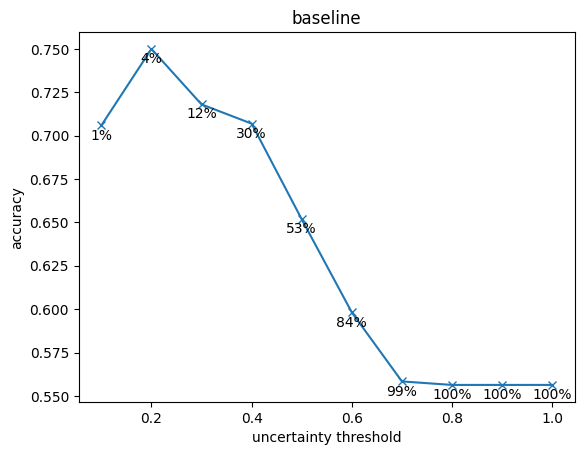

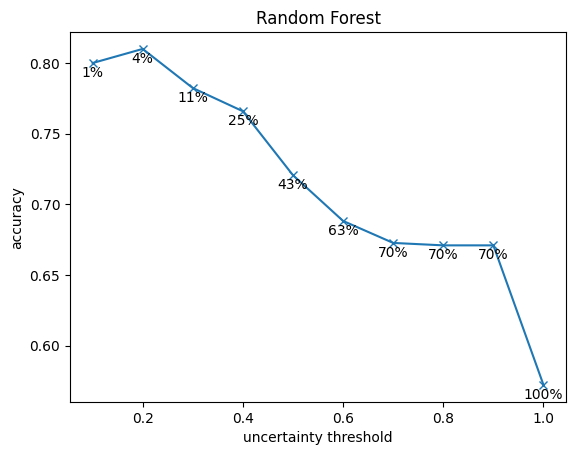

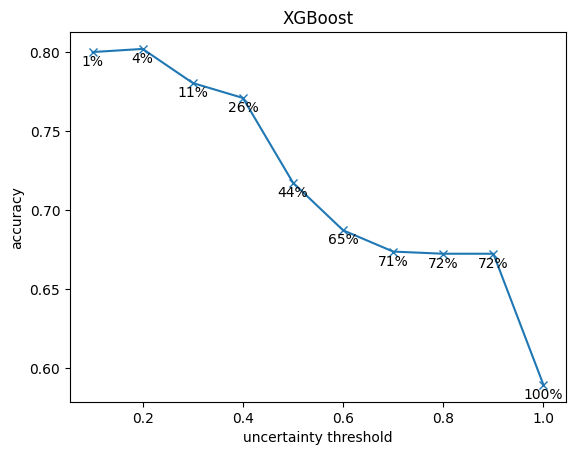

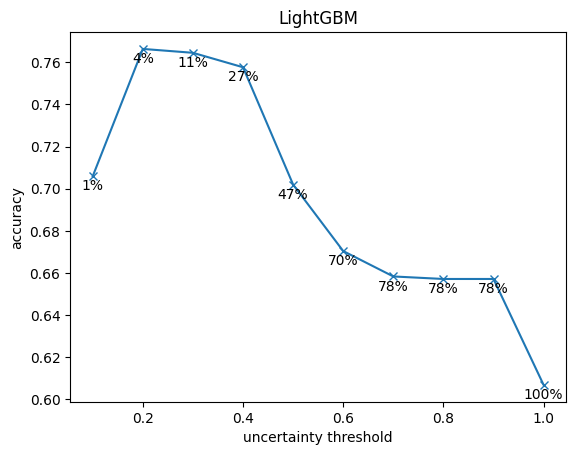

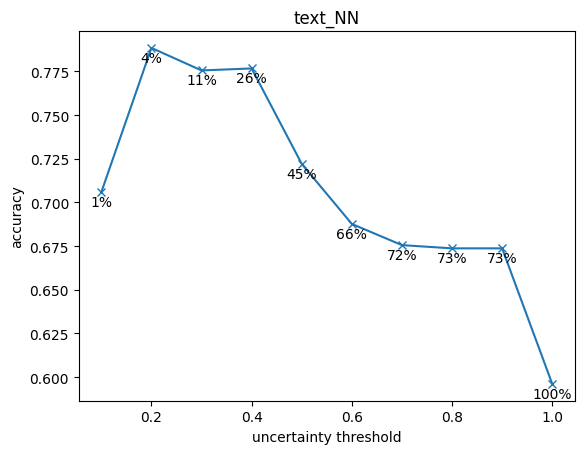

In [289]:
def calc_acc(model, model_data, uncertainty_threshold = 1, discount = 1.0):
    gt = model_data[model][:, 0]
    pred = model_data[model][:, 1]
    A,B,C,D = model_data[model][:, 2], model_data[model][:, 3], model_data[model][:, 4], model_data[model][:, 5]
    # total_evidence = (s + ns)
    total_evidence = np.maximum.reduce([A, B, C, D])
    # total_evidence = np.sum([A, B, C, D], axis=0)
    uncertainty = 1 - total_evidence * discount / 100
    mask = uncertainty <= uncertainty_threshold
    acc = (gt == pred)[mask].sum() / max(1, sum(mask))
    return acc, mask.mean()
def plot_accuracy(results, model_name):
    xs, ys, zs = results[:, 0], results[:, 1], results[:, 2]
    plt.plot(xs, ys, '-x')
    # zip joins x and y coordinates in pairs
    for x, y, z in zip(xs,ys, zs):
        label = "{:.0f}%".format(100 * z)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-10), # distance from text to points (x,y)
                     ha='center') 
    plt.xlabel('uncertainty threshold')
    plt.ylabel('accuracy')
    plt.title(f'{model_name}')
    plt.savefig(f'{model_name}.png')
    plt.show()
def get_acc_per_uncertainty(model, model_data, discount = 1.0, plot_results = True):
    results = []
    for i in range(10):
        threshold = (i + 1) / 10
        acc, perc_data = calc_acc(model, model_data, uncertainty_threshold = threshold, discount=discount)
        results.append([threshold, acc, perc_data])
    results = np.array(results)
    if plot_results:
        plot_accuracy(results, model)
    return results

results_gemma = {}
for model in combined_data.keys():
    results_gemma[model] = get_acc_per_uncertainty(model, combined_data)

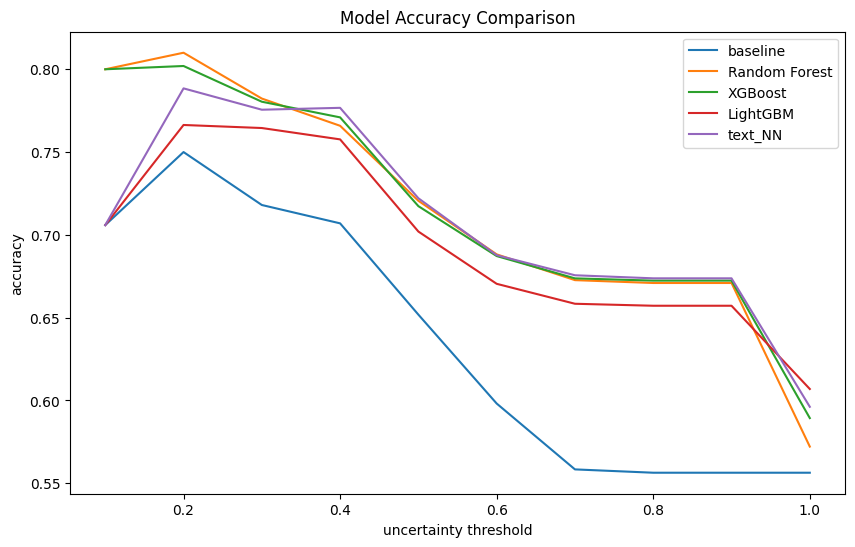

In [290]:
def plot_accuracy_multiple(models_results):
    """
    models_results 是一个列表，包含多个 (model_name, results) 的元组。
    model_name 是字符串，results 是对应模型的 10行3列 二维数组。
    """
    plt.figure(figsize=(10, 6))  # 设置图像大小

    for model in models_results:
        xs, ys, zs = models_results[model][:, 0], models_results[model][:, 1], models_results[model][:, 2]
        
        # 为每个模型画一条线
        plt.plot(xs, ys, label=model)
        
        # # 为每个模型的每个点添加注释
        # for x, y, z in zip(xs, ys, zs):
        #     label = "{:.0f}%".format(100 * z)
        #     plt.annotate(label,  # 这个是标注的文本
        #                  (x, y),  # 这些是标注的坐标
        #                  textcoords="offset points",  # 文本的显示位置
        #                  xytext=(0, -10),  # 文本与点的距离
        #                  ha='center')  # 水平对齐方式

    plt.xlabel('uncertainty threshold')
    plt.ylabel('accuracy')
    plt.title('Model Accuracy Comparison')
    plt.legend()  # 显示图例，区分不同模型
    plt.savefig('Model Accuracy Comparison.png')
    plt.show()

# 示例数据调用
# 假设model_list和results_list已经存在
plot_accuracy_multiple(results_gemma)

In [281]:
deep_test.shape[0] * 0.00430416

11.99999808

In [126]:
results_gemma

{'baseline': array([[0.1       , 0.91666667, 0.00430416],
        [0.2       , 0.86792453, 0.03802009],
        [0.3       , 0.7345679 , 0.11621234],
        [0.4       , 0.71182266, 0.29124821],
        [0.5       , 0.65031099, 0.51901004],
        [0.6       , 0.58648881, 0.83357245],
        [0.7       , 0.54697135, 0.98888092],
        [0.8       , 0.54555237, 1.        ],
        [0.9       , 0.54555237, 1.        ],
        [1.        , 0.54555237, 1.        ]]),
 'XGBoost': array([[0.1       , 1.        , 0.00394548],
        [0.2       , 0.90721649, 0.03479197],
        [0.3       , 0.81884058, 0.0989957 ],
        [0.4       , 0.79310345, 0.24964132],
        [0.5       , 0.73989899, 0.42611191],
        [0.6       , 0.68876404, 0.6384505 ],
        [0.7       , 0.66248117, 0.71413199],
        [0.8       , 0.66283716, 0.71807747],
        [0.9       , 0.66283716, 0.71807747],
        [1.        , 0.59074605, 1.        ]]),
 'NN_10': array([[0.1       , 0.91666667, 0.00430416]